### Loading Libraries

In [1]:
import math
import warnings  # Suppress the UserWarning from StandardScaler
import numpy as np
from numpy import array
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Sequential, Model
from keras.layers import LSTM, Dense, Input, Dropout
from scikeras.wrappers import KerasRegressor

### Scrapping Data from Yahoo Finance

In [2]:
#scrap dataset
ticker = 'AAPL'
aaplData = yf.download(ticker, '1981-01-01', '2024-07-03')
aaplData.to_csv('AAPL.csv')

[*********************100%%**********************]  1 of 1 completed


In [3]:
stockPrices = pd.read_csv('AAPL.csv')

### Exploratory Data Analysis (EDA)

In [4]:
stockPrices.isnull()

,Date,Open,High,Low,Close,Adj Close,Volume
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
10961,False,False,False,False,False,False,False
10962,False,False,False,False,False,False,False
10963,False,False,False,False,False,False,False
10964,False,False,False,False,False,False,False


In [5]:
stockPrices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10966 entries, 0 to 10965
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10966 non-null  object 
 1   Open       10966 non-null  float64
 2   High       10966 non-null  float64
 3   Low        10966 non-null  float64
 4   Close      10966 non-null  float64
 5   Adj Close  10966 non-null  float64
 6   Volume     10966 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 599.8+ KB


In [6]:
stockPrices.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
stockPrices.shape

(10966, 7)

In [8]:
stockPrices.size

76762

In [9]:
stockPrices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10966.000000,10966.000000,10966.000000,10966.000000,10966.000000,1.096600e+04
mean,21.972727,22.210259,21.746227,21.987218,21.191561,3.187964e+08
std,45.276573,45.766238,44.825709,45.315147,44.878262,3.356543e+08
min,0.049665,0.049665,0.049107,0.049107,0.037900,0.000000e+00
25%,0.299107,0.304688,0.291295,0.299107,0.242501,1.137262e+08
50%,0.529018,0.537946,0.520089,0.529576,0.431103,2.062550e+08
75%,20.087946,20.267857,19.848213,20.036160,17.220457,3.991050e+08
max,217.589996,220.380005,215.100006,220.270004,220.270004,7.421641e+09


In [10]:
stockPrices.isna()

,Date,Open,High,Low,Close,Adj Close,Volume
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
10961,False,False,False,False,False,False,False
10962,False,False,False,False,False,False,False
10963,False,False,False,False,False,False,False
10964,False,False,False,False,False,False,False


### Train-Test Split

In [11]:
testRatio = 0.2
trainingRatio = 1 - testRatio

trainingSize = int(trainingRatio * len(stockPrices))
testSize = int(testRatio * len(stockPrices))
print(f"Training Size: {trainingSize}")
print(f"Testing Size: {testSize}")

train = stockPrices[:trainingSize][["Close"]]  
test = stockPrices[trainingSize:][["Close"]].copy()  

Training Size: 8772
Testing Size: 2193


### Feature Engineering

In [12]:
## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    """
    Split time-series into training sequence X and outcome value Y
    Args:
        data - dataset
        N - window size, e.g., 50 for 50 days of historical stock prices
        offset - position to start the split
    """
    X, y = [], []
    for i in range(offset, len(data)):
        X.append(data[i - N: i])
        y.append(data[i])
    return np.array(X), np.array(y)

### Evaluation Metric Preparation

In [13]:
# Calculate the metrics RMSE and MAPE
def calculateRMSE(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

def calculateMAPE(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [14]:
def calculate_perf_metrics(var):
    ### RMSE
    rmse = calculateRMSE(
        np.array(stockPrices[trainingSize:]["Close"]),
        np.array(stockPrices[trainingSize:][var]),
    )
    ### MAPE
    mape = calculateMAPE(
        np.array(stockPrices[trainingSize:]["Close"]),
        np.array(stockPrices[trainingSize:][var]),
    )

    return rmse, mape

In [15]:
def plot_stock_trend(var, cur_title, stockprices=stockPrices):
    ax = stockprices[["Close", var, "200 Days"]].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")

## Simple Moving Average

RMSE for SMA: 7.755504090000262
MAPE for SMA: 6.023238413108351


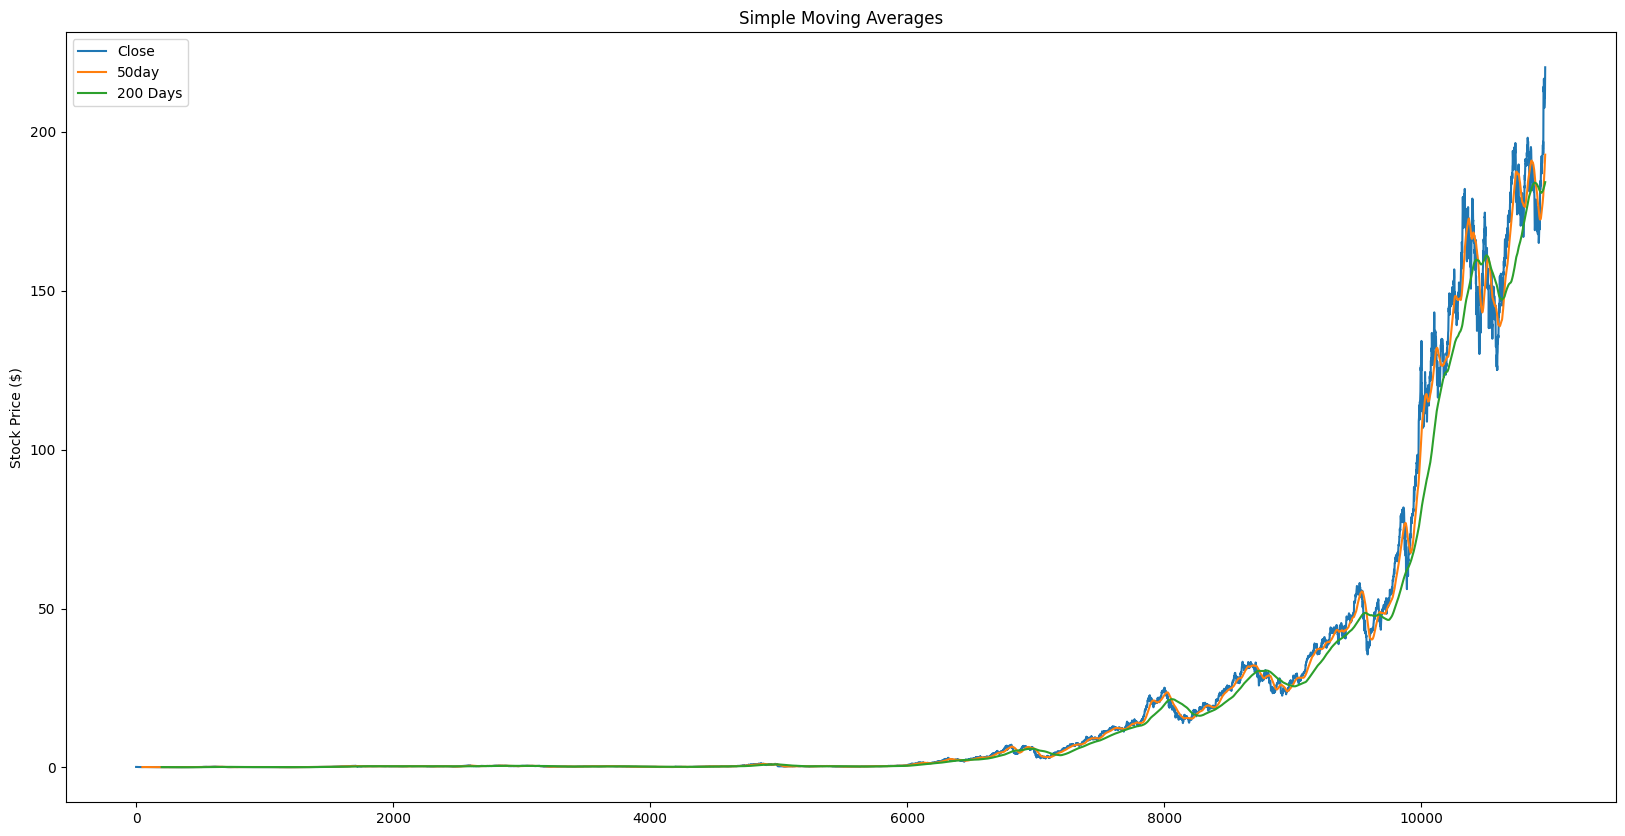

In [16]:
window_size = 50

window_var = f"{window_size}day"

stockPrices[window_var] = stockPrices["Close"].rolling(window_size).mean()

### Include a 200-day SMA for reference
stockPrices["200 Days"] = stockPrices["Close"].rolling(200).mean()

### Plot and performance metrics for SMA model
plot_stock_trend(var=window_var, cur_title="Simple Moving Averages")
rmse_sma, mape_sma = calculate_perf_metrics(var=window_var)

print(f"RMSE for SMA: {rmse_sma}")
print(f"MAPE for SMA: {mape_sma}")

## Exponential Moving Average

RMSE for EMA: 6.511487188724983
MAPE for EMA: 5.059738248115862


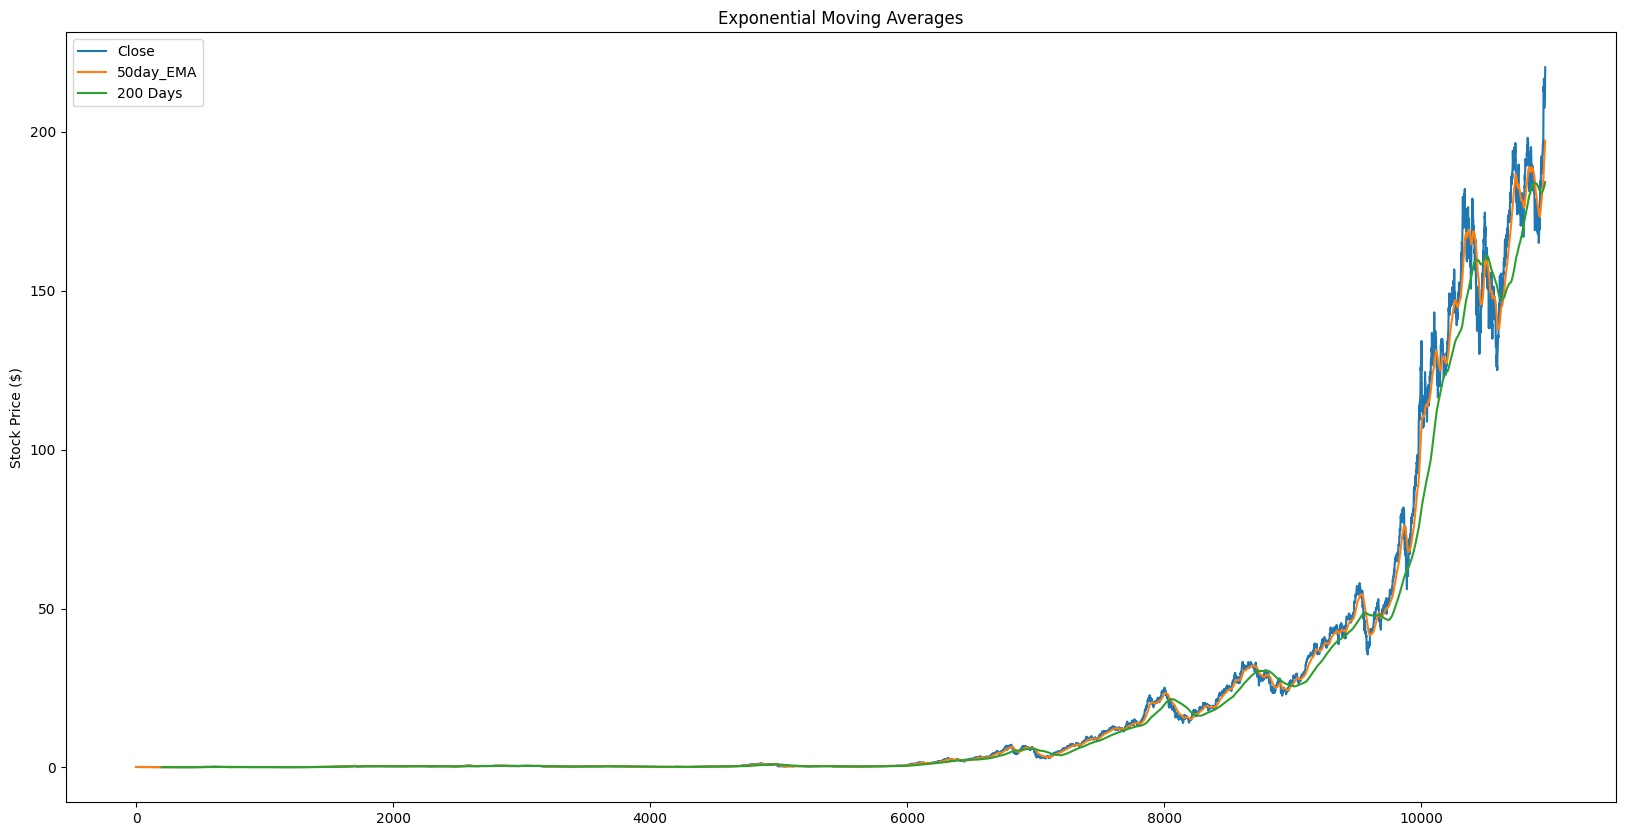

In [17]:
window_ema_var = f"{window_var}_EMA"

# Calculate the 50-day exponentially weighted moving average
stockPrices[window_ema_var] = (
    stockPrices["Close"].ewm(span=window_size, adjust=False).mean()
)
stockPrices["200 Days"] = stockPrices["Close"].rolling(200).mean()

### Plot and performance metrics for EMA model
plot_stock_trend(
    var=window_ema_var, cur_title="Exponential Moving Averages")
rmse_ema, mape_ema = calculate_perf_metrics(var=window_ema_var)

print(f"RMSE for EMA: {rmse_ema}")
print(f"MAPE for EMA: {mape_ema}")

## LSTM Model

In [18]:
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Scale our dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockPrices[["Close"]])
scaled_data_train = scaled_data[:train.shape[0]]

window_size = 50  # define window_size variable
# We use past 50 days’ stock prices for our training to predict the 51th day's closing price.
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

In [19]:
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("y_train shape:", y_train.shape)
print("y_train dtype:", y_train.dtype)

# Ensure data is in the correct format
X_train = np.array(X_train).astype('float32')
y_train = np.array(y_train).astype('float32')

# Reshape X_train if necessary (for LSTM input)
if len(X_train.shape) == 2:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print("After preprocessing:")
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("y_train shape:", y_train.shape)
print("y_train dtype:", y_train.dtype)

X_train shape: (8722, 50, 1)
X_train dtype: float64
y_train shape: (8722, 1)
y_train dtype: float64
After preprocessing:
X_train shape: (8722, 50, 1)
X_train dtype: float32
y_train shape: (8722, 1)
y_train dtype: float32


In [20]:
def create_model(layer_units=95, dropout_rate=0.2, optimizer='adam'):
    input_shape = (X_train.shape[1], 1) if len(X_train.shape) == 2 else (X_train.shape[1], X_train.shape[2])
    model = Sequential([
        LSTM(units=layer_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(units=layer_units),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

### Hyperparameter Tuning - Grid Search

In [21]:
model = KerasRegressor(
    model=create_model,
    layer_units=50,
    dropout_rate=0.3,
    optimizer='adam',
    batch_size=32,
    epochs=50,
    verbose=1  
)

In [22]:
param_grid = {
    'layer_units': [250],
    'dropout_rate': [0.2],
    'batch_size': [256],
    'epochs': [91, 92, 93, 94, 95]
}

In [23]:
try:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, n_jobs=1, verbose=1)
    grid_result = grid.fit(X_train, y_train)
    print("Best parameters found: ", grid_result.best_params_)
    print("Best score: ", grid_result.best_score_)
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Error type:", type(e))
    print("Error args:", e.args)
    import traceback
    traceback.print_exc()

Fitting 2 folds for each of 5 candidates, totalling 10 fits


c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - loss: 0.0352
Epoch 2/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - loss: 0.0015
Epoch 3/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - loss: 5.4928e-04
Epoch 4/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 461ms/step - loss: 4.2565e-04
Epoch 5/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 427ms/step - loss: 3.4862e-04
Epoch 6/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - loss: 3.6441e-04
Epoch 7/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - loss: 3.3566e-04
Epoch 8/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 378ms/step - loss: 3.3666e-04
Epoch 9/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 373ms/step - loss: 3.0809e-04
Epoch 10/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - loss: 3.2106e-04
Epoch 11/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - loss: 3.0636e-04
Epoch 12/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - loss: 3.2014e-04
Epoch 13/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - loss: 3.2176e-04
Epoch 14/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - loss: 3.7207e-04
Epoch 15

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - loss: 0.0574
Epoch 2/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - loss: 0.0014
Epoch 3/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 375ms/step - loss: 6.9894e-04
Epoch 4/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - loss: 5.1923e-04
Epoch 5/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - loss: 4.6011e-04
Epoch 6/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - loss: 4.4032e-04
Epoch 7/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - loss: 4.2047e-04
Epoch 8/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - loss: 4.2098e-04
Epoch 9/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - loss: 4.3089e-04
Epoch 10/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - loss: 4.0921e-04
Epoch 11/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - loss: 3.8029e-04
Epoch 12/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - loss: 3.8502e-04
Epoch 13/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - loss: 3.5762e-04
Epoch 14/91
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - loss: 3.5104e-04
Epoch 15/91
18/18 ━━

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - loss: 0.0489
Epoch 2/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - loss: 0.0024
Epoch 3/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - loss: 6.8573e-04
Epoch 4/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - loss: 4.4922e-04
Epoch 5/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - loss: 4.0042e-04
Epoch 6/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 374ms/step - loss: 3.8219e-04
Epoch 7/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step - loss: 3.5318e-04
Epoch 8/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - loss: 3.4360e-04
Epoch 9/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - loss: 3.4579e-04
Epoch 10/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - loss: 3.2846e-04
Epoch 11/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - loss: 3.3332e-04
Epoch 12/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - loss: 3.3763e-04
Epoch 13/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - loss: 3.4371e-04
Epoch 14/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - loss: 3.1501e-04
Epoch 15/92
18/18 ━

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 448ms/step - loss: 0.0606
Epoch 2/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - loss: 0.0019
Epoch 3/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step - loss: 6.4645e-04
Epoch 4/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 429ms/step - loss: 5.2982e-04
Epoch 5/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step - loss: 4.8426e-04
Epoch 6/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 439ms/step - loss: 4.4074e-04
Epoch 7/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 430ms/step - loss: 4.3926e-04
Epoch 8/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - loss: 4.4232e-04
Epoch 9/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 436ms/step - loss: 3.9756e-04
Epoch 10/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - loss: 3.9810e-04
Epoch 11/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 425ms/step - loss: 3.7637e-04
Epoch 12/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 427ms/step - loss: 3.6485e-04
Epoch 13/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 420ms/step - loss: 3.4594e-04
Epoch 14/92
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 442ms/step - loss: 3.4244e-04
Epoch 15/92
18/18 ━

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 426ms/step - loss: 0.0447
Epoch 2/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 407ms/step - loss: 0.0028
Epoch 3/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 409ms/step - loss: 6.3817e-04
Epoch 4/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 399ms/step - loss: 4.5484e-04
Epoch 5/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 407ms/step - loss: 3.6771e-04
Epoch 6/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 410ms/step - loss: 3.7455e-04
Epoch 7/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 412ms/step - loss: 3.5661e-04
Epoch 8/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step - loss: 3.3728e-04
Epoch 9/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 418ms/step - loss: 3.3730e-04
Epoch 10/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 449ms/step - loss: 3.1856e-04
Epoch 11/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - loss: 3.1572e-04
Epoch 12/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 413ms/step - loss: 3.2376e-04
Epoch 13/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - loss: 2.9313e-04
Epoch 14/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step - loss: 3.0458e-04
Epoch 15/93
18/18 ━

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 380ms/step - loss: 0.0638
Epoch 2/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 379ms/step - loss: 0.0024
Epoch 3/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - loss: 6.5372e-04
Epoch 4/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - loss: 4.9026e-04
Epoch 5/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 392ms/step - loss: 4.8410e-04
Epoch 6/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - loss: 4.6874e-04
Epoch 7/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 389ms/step - loss: 4.3897e-04
Epoch 8/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - loss: 4.7414e-04
Epoch 9/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - loss: 3.8946e-04
Epoch 10/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - loss: 4.0865e-04
Epoch 11/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - loss: 3.9797e-04
Epoch 12/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - loss: 3.8941e-04
Epoch 13/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - loss: 3.4305e-04
Epoch 14/93
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - loss: 3.5517e-04
Epoch 15/93
18/18 ━━

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 369ms/step - loss: 0.0404
Epoch 2/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - loss: 0.0020
Epoch 3/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - loss: 5.5248e-04
Epoch 4/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - loss: 3.9920e-04
Epoch 5/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - loss: 3.8933e-04
Epoch 6/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - loss: 3.8257e-04
Epoch 7/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 368ms/step - loss: 3.6549e-04
Epoch 8/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - loss: 3.4366e-04
Epoch 9/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 371ms/step - loss: 3.5932e-04
Epoch 10/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 371ms/step - loss: 3.2674e-04
Epoch 11/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - loss: 3.2669e-04
Epoch 12/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - loss: 3.2136e-04
Epoch 13/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - loss: 3.1288e-04
Epoch 14/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - loss: 3.4434e-04
Epoch 15/94
18/18 ━━

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 424ms/step - loss: 0.0535
Epoch 2/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 421ms/step - loss: 0.0016
Epoch 3/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 423ms/step - loss: 6.8060e-04
Epoch 4/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 424ms/step - loss: 5.0476e-04
Epoch 5/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 419ms/step - loss: 4.6768e-04
Epoch 6/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 420ms/step - loss: 4.4048e-04
Epoch 7/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 418ms/step - loss: 4.1349e-04
Epoch 8/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 430ms/step - loss: 3.8089e-04
Epoch 9/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 424ms/step - loss: 4.9939e-04
Epoch 10/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - loss: 4.0294e-04
Epoch 11/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 416ms/step - loss: 3.7751e-04
Epoch 12/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - loss: 3.9009e-04
Epoch 13/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - loss: 3.7882e-04
Epoch 14/94
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 420ms/step - loss: 3.3324e-04
Epoch 15/94
18/18 ━

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 372ms/step - loss: 0.0398
Epoch 2/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - loss: 0.0016
Epoch 3/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - loss: 6.2441e-04
Epoch 4/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - loss: 4.0815e-04
Epoch 5/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 381ms/step - loss: 3.9568e-04
Epoch 6/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - loss: 3.8495e-04
Epoch 7/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - loss: 3.8649e-04
Epoch 8/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 384ms/step - loss: 3.2320e-04
Epoch 9/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 390ms/step - loss: 3.2379e-04
Epoch 10/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - loss: 3.4264e-04
Epoch 11/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 383ms/step - loss: 3.3931e-04
Epoch 12/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 398ms/step - loss: 3.1068e-04
Epoch 13/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 398ms/step - loss: 3.1562e-04
Epoch 14/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 391ms/step - loss: 4.3326e-04
Epoch 15/95
18/18 ━━

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - loss: 0.0574
Epoch 2/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - loss: 0.0011
Epoch 3/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - loss: 6.1645e-04
Epoch 4/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 367ms/step - loss: 4.8630e-04
Epoch 5/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - loss: 4.8156e-04
Epoch 6/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - loss: 4.3575e-04
Epoch 7/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - loss: 4.1663e-04
Epoch 8/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - loss: 4.2389e-04
Epoch 9/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - loss: 4.0283e-04
Epoch 10/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 358ms/step - loss: 3.9706e-04
Epoch 11/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - loss: 3.7329e-04
Epoch 12/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 362ms/step - loss: 3.8602e-04
Epoch 13/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 358ms/step - loss: 3.6039e-04
Epoch 14/95
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - loss: 3.4270e-04
Epoch 15/95
18/18 ━━

c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 379ms/step - loss: 0.0337
Epoch 2/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 374ms/step - loss: 6.6222e-04
Epoch 3/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 374ms/step - loss: 4.4081e-04
Epoch 4/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 374ms/step - loss: 3.8984e-04
Epoch 5/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 373ms/step - loss: 3.8093e-04
Epoch 6/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 379ms/step - loss: 3.5042e-04
Epoch 7/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 374ms/step - loss: 3.7053e-04
Epoch 8/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 379ms/step - loss: 3.4069e-04
Epoch 9/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 380ms/step - loss: 3.9617e-04
Epoch 10/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 375ms/step - loss: 4.1124e-04
Epoch 11/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 380ms/step - loss: 3.3383e-04
Epoch 12/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 375ms/step - loss: 2.8322e-04
Epoch 13/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 376ms/step - loss: 2.7140e-04
Epoch 14/94
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 377ms/step - loss: 2.8901e-04
Ep

In [24]:
# print("Best parameters found: ", grid_result.best_params_)

In [25]:
best_params = {k.replace('model__', ''): v for k, v in grid_result.best_params_.items()}
print("Best parameters found: ", best_params)

Best parameters found:  {'batch_size': 256, 'dropout_rate': 0.2, 'epochs': 94, 'layer_units': 250}


In [26]:
final_model = create_model(
    layer_units=best_params['layer_units'],
    dropout_rate=best_params['dropout_rate'],
    optimizer='adam'
)

In [27]:
final_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 50, 250)        │       252,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 50, 250)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 250)            │       501,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           251 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753,251 (2.87 MB)

 Trainable params: 753,251 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Callbacks - to prevent overfitting by cutting short epochs and save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [29]:
history = final_model.fit(
    X_train,
    y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2,
    verbose=1,
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/94
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 490ms/step - loss: 0.0588 - val_loss: 0.0102
Epoch 2/94
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - loss: 0.0016 - val_loss: 0.0090
Epoch 3/94
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 447ms/step - loss: 5.7414e-04 - val_loss: 0.0098
Epoch 4/94
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - loss: 4.9828e-04 - val_loss: 0.0094
Epoch 5/94
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 452ms/step - loss: 4.7337e-04 - val_loss: 0.0085
Epoch 6/94
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 445ms/step - loss: 4.4839e-04 - val_loss: 0.0082
Epoch 7/94
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 449ms/step - loss: 4.3848e-04 - val_loss: 0.0078
Epoch 8/94
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 444ms/step - loss: 4.2368e-04 - val_loss: 0.0071
Epoch 9/94
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 449ms/step - loss: 4.0922e-04 - val_loss: 0.0067
Epoch 10/94
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 446ms/step - loss: 3.8963e-04 - val_loss: 0.0060
Epoch 11/94
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 447ms/step - loss: 3.8486e-04 - val_loss: 0.0055
Epoch

### Validate on Testing Set

In [30]:
best_model = grid_result.best_estimator_

In [31]:
# Preprocess test data
def preprocess_testdat(data=stockPrices, scaler=scaler, window_size=window_size, test=test):
    raw = data["Close"][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1, 1)
    raw = scaler.transform(raw)

    X_test = [raw[i - window_size: i, 0] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat().astype('float32')

# Use the best model from grid search for predictions
predicted_price_ = best_model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Ensure test DataFrame has a column to store predictions
test["Predictions_lstm"] = predicted_price

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step


In [32]:
# Evaluate performance
rmse_lstm = calculateRMSE(np.array(test["Close"]), np.array(test["Predictions_lstm"]))
mape_lstm = calculateMAPE(np.array(test["Close"]), np.array(test["Predictions_lstm"]))

print(f"RMSE for LSTM: {rmse_lstm}")
print(f"MAPE for LSTM: {mape_lstm}")

RMSE for LSTM: 17.527979091850025
MAPE for LSTM: 8.226418338136032


In [33]:
def plot_stock_trend_lstm(train, test):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(train.index, train["Close"], label="Train Closing Price")
    ax.plot(test.index, test["Close"], label="Test Closing Price")
    ax.plot(test.index, test["Predictions_lstm"], label="Predicted Closing Price")
    ax.set_title("LSTM Model")
    ax.set_xlabel("Date")
    ax.set_ylabel("Stock Price (USD $)")
    ax.legend()
    plt.show()

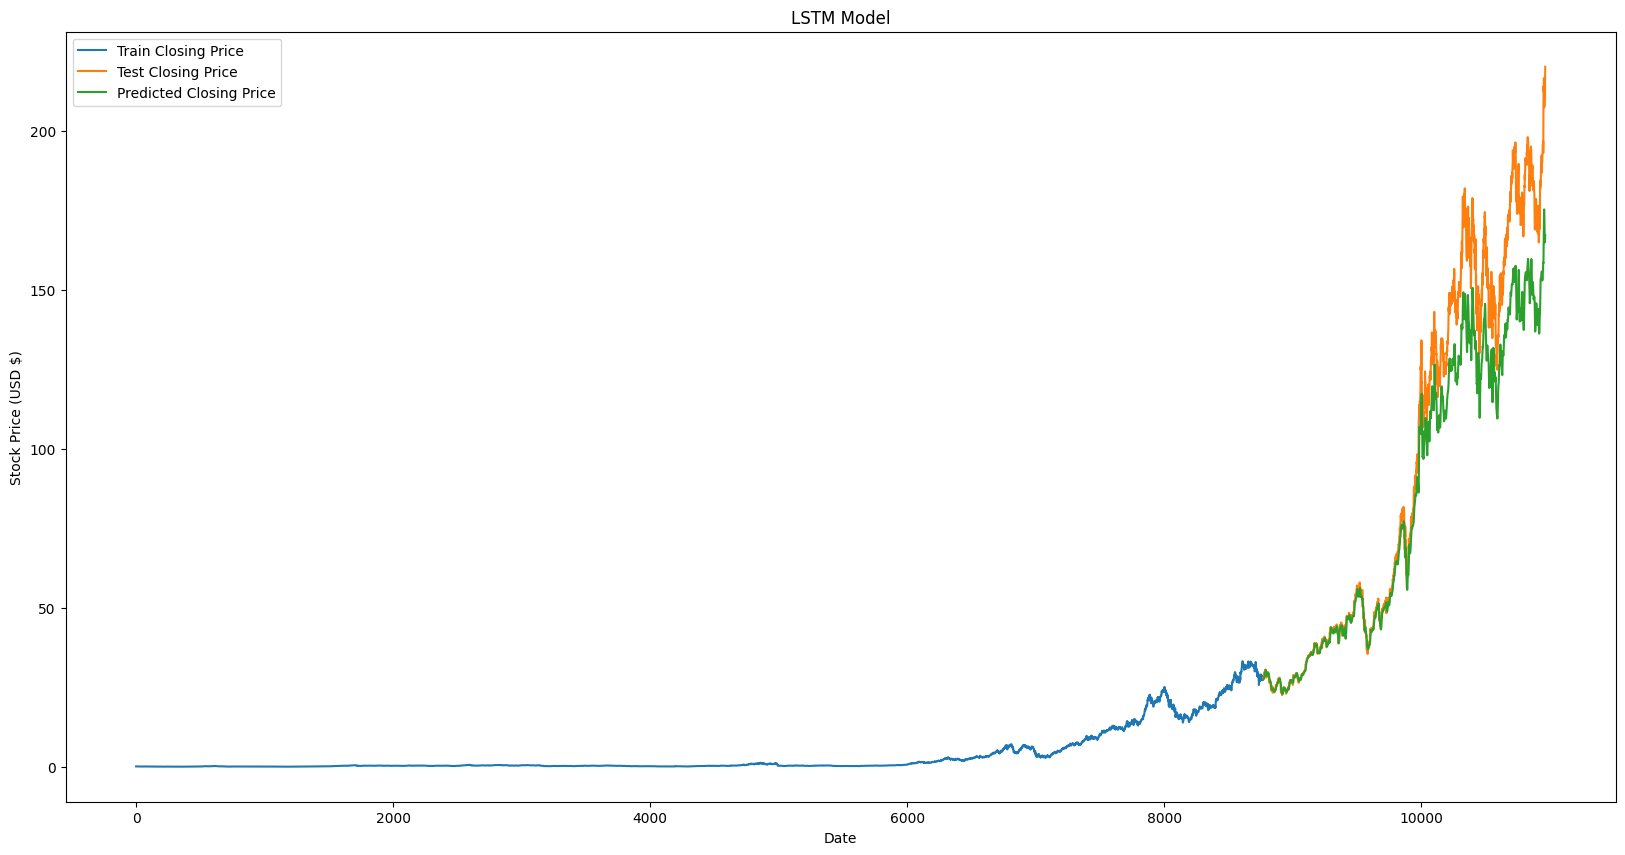

In [34]:
plot_stock_trend_lstm(train, test)